#Mengimport Library

In [1]:
import csv
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Dense, Embedding, Dropout,
    Conv1D, BatchNormalization, LSTM
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

### Memuat Data Hasil Pelabelan

In [2]:
df_clean = pd.read_csv('data_label.csv')

##SKEMA 1
### Pelatihan: TensorFlow (Sequential)
### Ekstraksi Fitur: Tokenizer + Embedding
### Pembagian Data: 80/20

In [3]:
df_clean['Review_Final'] = df_clean['Review_Final'].fillna('').astype(str)

texts = df_clean['Review_Final']
labels = df_clean['sentimen_lexicon']

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    texts, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

# Tokenisasi
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(texts)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
sequences_training  = tokenizer.texts_to_sequences(X_train)
sequences_testing  = tokenizer.texts_to_sequences(X_test)
padded_training = tf.keras.preprocessing.sequence.pad_sequences(sequences_training, maxlen=100, padding='post', truncating='post')
padded_testing = tf.keras.preprocessing.sequence.pad_sequences(sequences_testing, maxlen=100, padding='post', truncating='post')

# Modeling
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_training, y_train, epochs=5, batch_size=32, validation_data=(padded_testing, y_test))
model.save('tf_model.h5')
joblib.dump(tokenizer, 'tf_tokenizer.pkl')
joblib.dump(le, 'tf_label_encoder.pkl')

# Evaluate
test_loss, test_acc = model.evaluate(padded_testing, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/5
3010/3010 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - accuracy: 0.5379 - loss: 0.8934 - val_accuracy: 0.8949 - val_loss: 0.3191
Epoch 2/5
3010/3010 ━━━━━━━━━━━━━━━━━━━━ 77s 15ms/step - accuracy: 0.8995 - loss: 0.3068 - val_accuracy: 0.9421 - val_loss: 0.1871
Epoch 3/5
3010/3010 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - accuracy: 0.9303 - loss: 0.2153 - val_accuracy: 0.9411 - val_loss: 0.2454
Epoch 4/5
3010/3010 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - accuracy: 0.9388 - loss: 0.1906 - val_accuracy: 0.9630 - val_loss: 0.1285
Epoch 5/5
3010/3010 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.9536 - loss: 0.1498 - val_accuracy: 0.9662 - val_loss: 0.1270


753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9660 - loss: 0.1228
Test accuracy: 0.9661502838134766


Model menunjukkan performa yang sangat baik dengan akurasi uji mencapai 96.61%. Proses pelatihan berjalan optimal, ditunjukkan oleh peningkatan akurasi dan penurunan loss yang cukup konsisten meskipun terdapat penurunan akurasi pada epoch 3 namun tidak signifikan.

### Visualisasi Akurasi dan Loss Selama Pelatihan Model

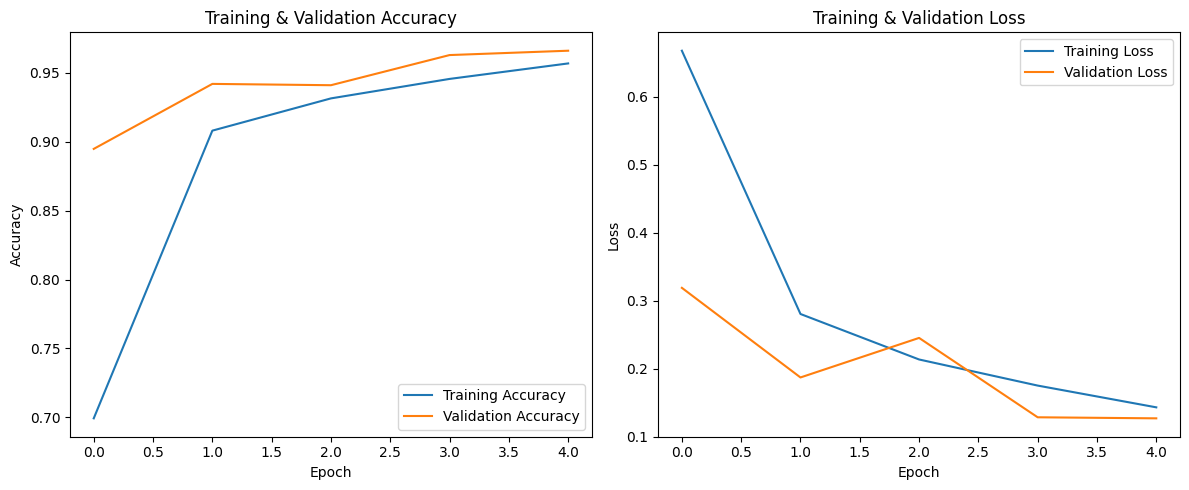

In [4]:
# Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

 ### Evaluasi Model Menggunakan Classification Report dan Confusion Matrix

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.99      0.95      0.97      8025
     neutral       0.94      0.97      0.95      8026
    positive       0.98      0.98      0.98      8026

    accuracy                           0.97     24077
   macro avg       0.97      0.97      0.97     24077
weighted avg       0.97      0.97      0.97     24077



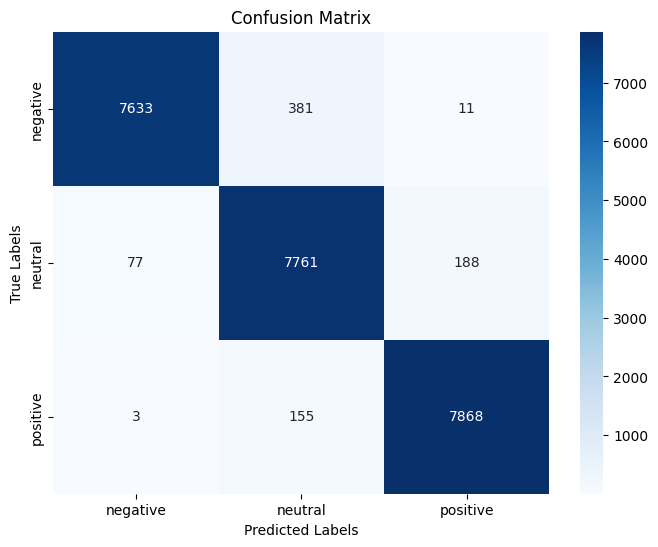

In [5]:
y_pred_probs = model.predict(padded_testing)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = le.classes_

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Model menunjukkan akurasi klasifikasi yang sangat tinggi di ketiga kelas, dengan rata-rata akurasi (macro avg) mencapai 97%.
Kesalahan yang paling sering terjadi adalah antara kelas neutral dan negative karena keduanya sering memiliki konteks yang mirip.

##SKEMA 2
### Pelatihan: Logistic Regression
### Ekstraksi Fitur: TF-IDF
### Pembagian Data: 70/30

In [6]:
df_clean['Review_Final'] = df_clean['Review_Final'].fillna('').astype(str)
texts = df_clean['Review_Final']
labels = df_clean['sentimen_lexicon']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

joblib.dump(model, 'logreg_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

# Predict
y_pred = model.predict(X_test_tfidf)

 ### Evaluasi Model Menggunakan Classification Report dan Confusion Matrix


Accuracy: 0.9144

Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.93      0.93     12038
     neutral       0.88      0.88      0.88     12039
    positive       0.93      0.94      0.93     12039

    accuracy                           0.91     36116
   macro avg       0.91      0.91      0.91     36116
weighted avg       0.91      0.91      0.91     36116



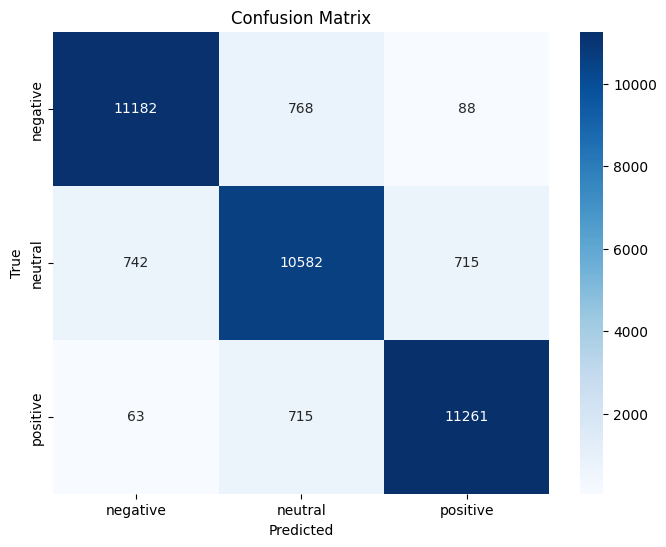

In [7]:
# Evaluasi
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Akurasi keseluruhan model mencapai 91.44%, menunjukkan performa yang sangat baik secara umum meski kelas neutral memiliki skor sedikit lebih rendah.

### Visualisasi Fitur TF-IDF Teratas Berdasarkan Koefisien Logistic Regression

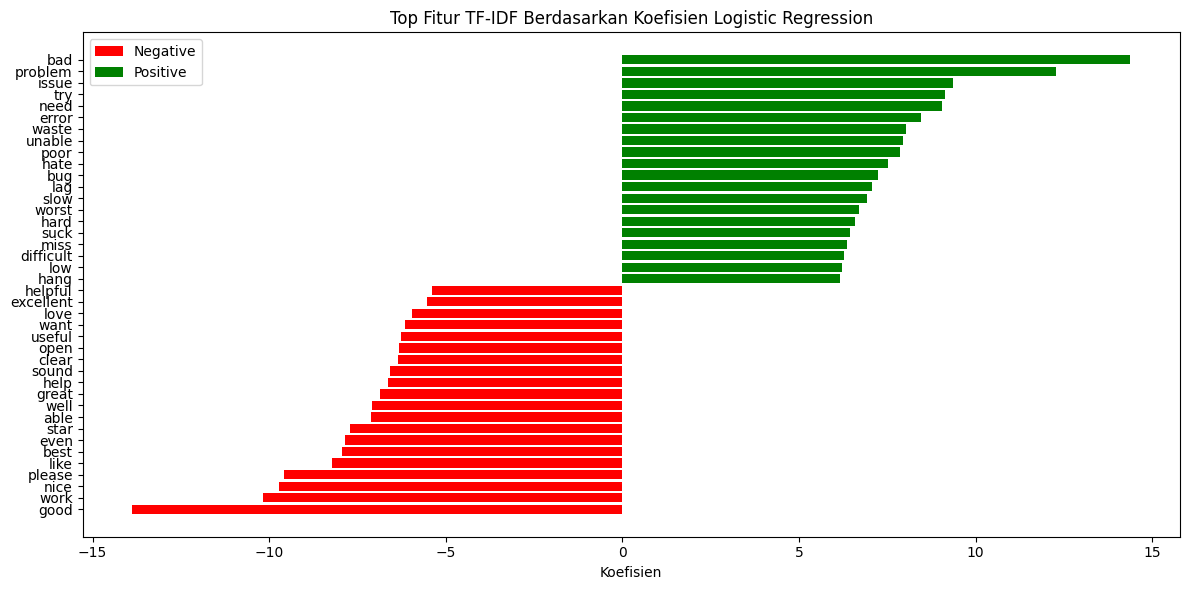

In [8]:
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]

plt.figure(figsize=(12,6))
plt.barh([feature_names[i] for i in top_neg_idx], coefs[top_neg_idx], color='red', label='Negative')
plt.barh([feature_names[i] for i in top_pos_idx], coefs[top_pos_idx], color='green', label='Positive')
plt.title("Top Fitur TF-IDF Berdasarkan Koefisien Logistic Regression")
plt.xlabel("Koefisien")
plt.legend()
plt.tight_layout()
plt.show()

##SKEMA 3
### Pelatihan: SVM (LinearSVC)
### Ekstraksi Fitur: TF-IDF
### Pembagian Data: 70/30

Persiapan Data

In [9]:
df_clean['Review_Final'] = df_clean['Review_Final'].fillna('').astype(str)
texts = df_clean['Review_Final']
labels = df_clean['sentimen_lexicon']

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42)

# Ekstraksi Fitur
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Pelatihan Model SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(vectorizer, 'svm_vectorizer.pkl')

['svm_vectorizer.pkl']

 ### Evaluasi Model Menggunakan Classification Report dan Confusion Matrix

Akurasi Training: 0.9517
Akurasi Test: 0.9290

Classification Report (Test):
               precision    recall  f1-score   support

    negative       0.92      0.97      0.94     12038
     neutral       0.94      0.85      0.89     12039
    positive       0.93      0.97      0.95     12039

    accuracy                           0.93     36116
   macro avg       0.93      0.93      0.93     36116
weighted avg       0.93      0.93      0.93     36116



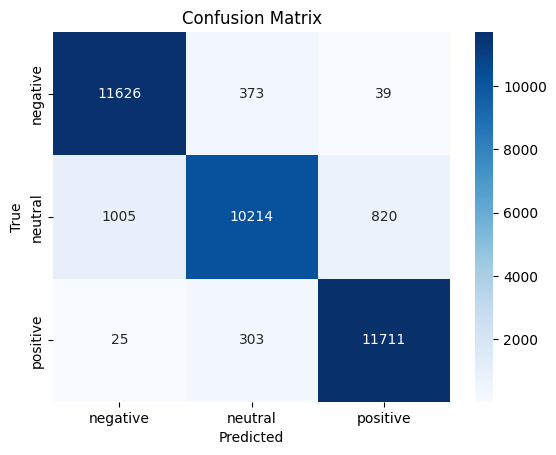

In [10]:
# Evaluasi
y_train_pred = svm_model.predict(X_train_tfidf)
acc_train = accuracy_score(y_train, y_train_pred)
print(f"Akurasi Training: {acc_train:.4f}")
y_pred = svm_model.predict(X_test_tfidf)
acc_test = accuracy_score(y_test, y_pred)
print(f"Akurasi Test: {acc_test:.4f}")
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Perbedaan akurasi training (95.17%) dan testing (92.90%) yang kecil menunjukkan bahwa model memiliki generalisasi yang baik dan tidak mengalami overfitting.